# Imports and constants

In [1]:
import numpy as np
import tensorflow as tf
import pandas as pd
import os
import cv2 as cv
import json
from pycocotools.coco import COCO
import matplotlib.pyplot as plt
from math import ceil

In [2]:
if tf.test.gpu_device_name(): 

    print('Default GPU Device:{}'.format(tf.test.gpu_device_name()))

else:

   print("Please install GPU version of TF")

Default GPU Device:/device:GPU:0


In [3]:
# directory with training images
train_dir = "D:/Datasets/COCO/Images/train2014/"

# validation directory
valid_dir = "D:/Datasets/COCO/Images/val2014/"

# test direstory
test_dir = "D:/Datasets/COCO/Images/test2014/"

# directory with the annotations bounding boxes
data_annotation_path_train = "D:/Datasets/COCO/Annotations/annotations/instances_train2014.json"
data_annotation_path_validation = "D:/Datasets/COCO/Annotations/annotations/instances_val2014.json"
data_annotation_path_test = "D:/Datasets/COCO/Image_info/annotations/image_info_test2014.json"

In [4]:
# initialize COCO api for instance annotations
coco_train = COCO(data_annotation_path_train)
coco_validation = COCO(data_annotation_path_validation)
coco_test = COCO(data_annotation_path_test)

loading annotations into memory...
Done (t=9.05s)
creating index...
index created!
loading annotations into memory...
Done (t=4.83s)
creating index...
index created!
loading annotations into memory...
Done (t=0.07s)
creating index...
index created!


In [5]:
# number of classes 
global num_classes_coco
num_classes_coco = max(coco_train.cats.keys())

In [6]:
# temporary grid size
grid_size = (25,37)
images_dim = (600,400)

# Utils

## Build the generator, detection grid and other utils

In [7]:
def Get_images_batch_from_COCO(batch_size, coco, grid_size, images_dim, dir_, train_gen):
    ''' This function produces the batches for the training'''
    
    # get all images containing given categories, select one at random
    catIds = coco.getCatIds(catNms=coco.cats)

    # get all images through their IDs
    imgIds = coco.getImgIds(catIds=catIds )
    
    while True:
        # iamges batch
        batch = []
        batch_anns  = []
        detection_grid = []
        
        for i in range(batch_size):

            # random select an image and its annotations
            img = coco.loadImgs(imgIds[np.random.randint(0,len(imgIds))])[0]
            annIds = coco.getAnnIds(imgIds=img['id'], catIds=catIds, iscrowd=None)

            ### load the image and the annotations ###
            image = cv.imread(os.path.join(dir_,img["file_name"]))
            
            # cvtColor changes the color conversion
            rgb_image = cv.cvtColor(image, cv.COLOR_BGR2RGB)
            image_H = rgb_image.shape[0]
            image_W = rgb_image.shape[1]
            
            print('Image_H,Image_W = {}'.format((image_H,image_W)))
            
            # resize the image
            rgb_image = cv.resize(rgb_image, images_dim)
            print('Rescaled image dimensions {}'.format(rgb_image.shape))
            
            #load annotations
            anns = coco.loadAnns(annIds)

            # append the image to the batch and annotations to batch_anns
            batch.append(rgb_image)
            temp_annotations = Parse_annotations(anns,image_H,image_W)
            batch_anns.append(temp_annotations)       
            
            ## build detection grid
            detection_grid.append(Build_detection_grid(temp_annotations,grid_size,num_classes_coco))    
            
        yield (np.array(batch, dtype='object').astype('float32'), np.array(detection_grid, dtype='object').astype('float32'))
        

    
                
def Parse_annotations(annotations,image_H,image_W):
    '''
    This function returns a list of lists. Each element of the main list contains the parameters of a of a bounding box:
    
    - x: center coordinate x 
    - y: center coordinate y 
    - w: width of the bounding box
    - h: height of the bounding box
    - class: class of the object inside the bounding box
    
    '''
    print('Parsing...')
    data = []
    for annotation in annotations:
        bbox = Rescale_BB_coordinates(annotation['bbox'],image_H,image_W)
        category_id = annotation['category_id']
        bbox.append(category_id)
        data.append(bbox)
    print('Done!')
    return data

def Rescale_BB_coordinates(data,image_H,image_W):
    '''rescale BB coordinates according to iamge dimensions:
    - output: center_x, center_y, width, height 
    - input: upper_left_x, upper_left_y, width, height'''
    print('Rescaling data with factors Image_H, image_W {}'.format((image_H,image_W)))
    n_data = []
    n_data.append((data[0]+data[2]/2)/image_W) # x
    n_data.append((data[1]+data[3]/2)/image_H) # y
    n_data.append((data[2])/image_W) # w 
    n_data.append((data[3])/image_H) # h
    print('Done!')
    return n_data
 

In [8]:
def Build_detection_grid(annotations,grid_size,num_classes,priors=[(1.0,1.0)]):
    '''This function builds the detection grid associated with each image:
    - input: image_size = (image_Width, image_Height)
    - output: (grid_size[0],grid_size[1],B*(5+C)) where B is the number of priors and C the number of classes 
    '''
    
    # initialize the grid
    grid_volume = (grid_size[0],grid_size[1],len(priors)*(5+num_classes))
    grid = np.zeros(grid_volume)
        
    for annotation in annotations:
        
        # unpack annotations
        x,y,w,h,label = annotation
        
        # find the Grid Cell (GC) responsible for the detection        
        resp_GC_x = int(x*grid_size[0])
        resp_GC_y = int(y*grid_size[1])
            
        for prior in priors:
        
            # create labels vector
            labels = np.zeros(num_classes_coco)
            # pay attention that the correct label is equal to the position where labels==1 +1
            labels[label-1]=1

            # fill responsible Grid Cell (1:boxiness)
            grid[resp_GC_x,resp_GC_y,:5] = x,y,w,h,1
            grid[resp_GC_x,resp_GC_y,5:] = labels
    
    return grid

## Utils for drawing bounding boxes and detection grids

In [9]:
def Norm2Orig(x0,y0,w,h,image_size):
    '''Changes the coordinates from the scale [0,1] to the original annotation size'''
    image_H = image_size[0] 
    image_W = image_size[1]
    center_x = int(x0*image_W)
    center_y = int(y0*image_H)
    W = int(w*image_W)
    H = int(h*image_H)
    return center_x,center_y,W,H

def Draw_BB(orig_image, image_datas, coco, fontscale=.7, bb_thickness=2):
    
    '''Draw bounding boxes on an image
    
    - output: copy of the original image with overlapped BB
    - input: image, annotations for the image, coco '''
    
    # copy the original image to not modify the original
    image = np.copy(orig_image).astype(int)
    image_H = image.shape[0]
    image_W = image.shape[1]
    
    for image_data in image_datas:
        
        try:
            # unpack image data
            x0, y0, w, h, label_ = image_data
        except: 
            # unpack image data with boxiness
            x0, y0, w, h, boxiness,  label_ = image_data
        
        # rescale the center and dimensions of the BB
        cetnter_x,center_y,W,H = Norm2Orig(x0,y0,w,h,(image_H,image_W))
        
        # build start and stop point for bb
        start_point = (cetnter_x-int(W/2), center_y+int(H/2))
        stop_point = (cetnter_x+int(W/2), center_y-int(H/2))

        # draw the rectangle
        image = cv.rectangle(image, start_point, stop_point, color=(0,0,255), thickness=5)
        
        # draw bboxes centers
        cv.circle(image,(cetnter_x,center_y),radius=0,color=(0,0,255),thickness=10)

        # write BB class
        try:
            label = coco.cats[int(label_)]['name']
            text_origin = start_point
            font = cv.FONT_HERSHEY_SIMPLEX 
            fontScale=fontscale
            color=(0,255,0)
            thickness=bb_thickness
            image = cv.putText(image, label, text_origin, font,  fontScale, color, thickness, cv.LINE_AA)
        except Exception as e:
            print(e)
    
    return image

def Draw_grid(orig_image,grid_size):
    '''This function draws the detection grid on a copy of the original image
    
    -inputs:original image and grid sizes
    -output:copy of the original image with the grid on top
    
    '''
    
    # copy the original image to not modify the original
    image = np.copy(orig_image)
    image_H = image.shape[0]
    image_W = image.shape[1]
    
    # draw vertical lines
    for i in range(grid_size[0]):
        start = (int(image_W*i/grid_size[0]),0)
        stop = (int(image_W*i/grid_size[0]),image_H)
        cv.line(image,start,stop,(255,0,0),2,2)
        
    # draw orizontal lines
    for j in range(grid_size[1]):
        start = (0,int(image_H*j/grid_size[0]))
        stop = (image_W,int(image_H*j/grid_size[0]))
        cv.line(image,start,stop,(255,0,0),2,2)
        
    return image

def DetectionGrid2ImageDetection(detection_grid):
    
    '''This function returns an array of size (batch_size, ). Each of the batches contains a list of lists containing the bboxes
       coordinates and parameters. The output should be correctly interpreted by the DrawBBo function.
    '''
    
    def Unpack_grid(grid,detections_coord_x,detections_coord_y,i):

        # positions of detections on the grid 
        posX,posY = detections_coord_x[i],detections_coord_y[i]

        # current box parameters
        x = grid[posX,posY,0]
        y = grid[posX,posY,1]
        w = grid[posX,posY,2]
        h = grid[posX,posY,3]
        boxiness = grid[posX,posY,4]
        label = np.argmax(grid[posX,posY,5:]) + 1

        return x,y,w,h,boxiness,label
        
    bboxes = []

    for grid in detection_grid:

        #current bounding box
        current_image_bboxes = []

        # x layer
        first_layer = grid[:,:,0]
        detections_coord_x, detections_coord_y = np.where(first_layer>0)

        for i in range(len(detections_coord_x)):

            x,y,w,h,boxiness,label = Unpack_grid(grid,detections_coord_x,detections_coord_y,i)

            current_image_bboxes.append([x,y,w,h,boxiness,label])

        bboxes.append(np.array(current_image_bboxes))

    return np.array(bboxes, dtype='object')

# Run

In [10]:
batch_ = 8

In [11]:
#standard generators with yield
training_gen = Get_images_batch_from_COCO(batch_, coco_train, grid_size, images_dim, train_dir,True)
validation_gen = Get_images_batch_from_COCO(batch_, coco_validation, grid_size, images_dim, valid_dir,True)
test_gen = Get_images_batch_from_COCO(batch_, coco_test, grid_size, images_dim, test_dir, False)

# train_gen

In [12]:
a,b = training_gen.__next__()

Image_H,Image_W = (478, 640)
Rescaled image dimensions (400, 600, 3)
Parsing...
Rescaling data with factors Image_H, image_W (478, 640)
Done!
Rescaling data with factors Image_H, image_W (478, 640)
Done!
Done!
Image_H,Image_W = (429, 640)
Rescaled image dimensions (400, 600, 3)
Parsing...
Rescaling data with factors Image_H, image_W (429, 640)
Done!
Rescaling data with factors Image_H, image_W (429, 640)
Done!
Rescaling data with factors Image_H, image_W (429, 640)
Done!
Rescaling data with factors Image_H, image_W (429, 640)
Done!
Rescaling data with factors Image_H, image_W (429, 640)
Done!
Rescaling data with factors Image_H, image_W (429, 640)
Done!
Rescaling data with factors Image_H, image_W (429, 640)
Done!
Rescaling data with factors Image_H, image_W (429, 640)
Done!
Rescaling data with factors Image_H, image_W (429, 640)
Done!
Rescaling data with factors Image_H, image_W (429, 640)
Done!
Done!
Image_H,Image_W = (640, 480)
Rescaled image dimensions (400, 600, 3)
Parsing...
Resc

In [27]:
for i in range(8):
    print('The max is {}'.format(max(b[i,:,:,:4].flatten())))

The max is 0.7451778054237366
The max is 0.575279712677002
The max is 0.8175104260444641
The max is 0.7958548069000244
The max is 0.9797656536102295
The max is 0.8352968692779541
The max is 0.9328941106796265
The max is 0.8192812204360962


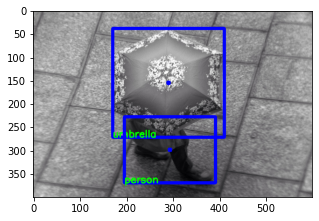

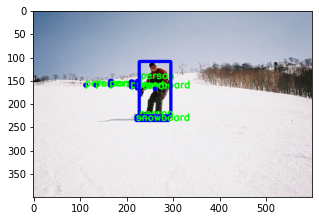

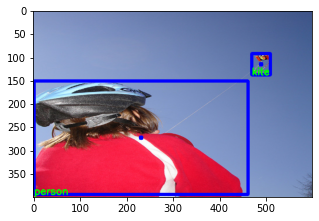

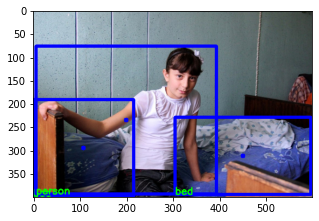

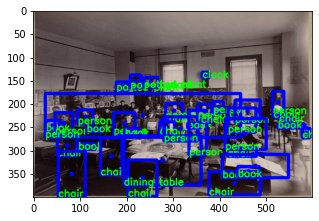

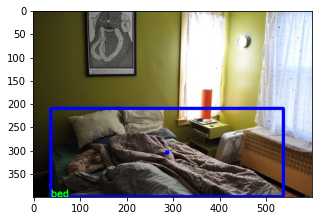

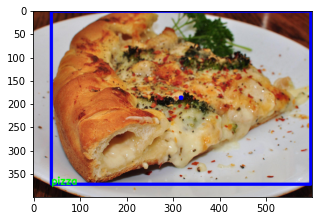

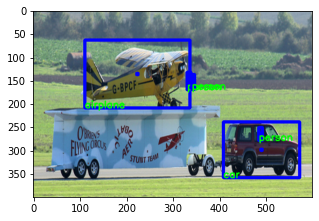

In [14]:
for i in range(a.shape[0]):
    fig, ax = plt.subplots(figsize=(5,5))
    bboxes = DetectionGrid2ImageDetection(b)
    image = Draw_BB(a[i,...], bboxes[i], coco_train)
    ax.imshow(image)
    plt.show()

# validation gen

In [15]:
c,d = validation_gen.__next__()

Image_H,Image_W = (427, 640)
Rescaled image dimensions (400, 600, 3)
Parsing...
Rescaling data with factors Image_H, image_W (427, 640)
Done!
Rescaling data with factors Image_H, image_W (427, 640)
Done!
Rescaling data with factors Image_H, image_W (427, 640)
Done!
Rescaling data with factors Image_H, image_W (427, 640)
Done!
Rescaling data with factors Image_H, image_W (427, 640)
Done!
Rescaling data with factors Image_H, image_W (427, 640)
Done!
Done!
Image_H,Image_W = (480, 640)
Rescaled image dimensions (400, 600, 3)
Parsing...
Rescaling data with factors Image_H, image_W (480, 640)
Done!
Rescaling data with factors Image_H, image_W (480, 640)
Done!
Rescaling data with factors Image_H, image_W (480, 640)
Done!
Rescaling data with factors Image_H, image_W (480, 640)
Done!
Rescaling data with factors Image_H, image_W (480, 640)
Done!
Rescaling data with factors Image_H, image_W (480, 640)
Done!
Rescaling data with factors Image_H, image_W (480, 640)
Done!
Done!
Image_H,Image_W = (640

In [28]:
for i in range(8):
    print('The max is {}'.format(max(d[i,:,:,:4].flatten())))

The max is 0.958688497543335
The max is 0.9792343974113464
The max is 0.7282291650772095
The max is 0.8840000033378601
The max is 0.9907484650611877
The max is 0.7477166056632996
The max is 0.9228125214576721
The max is 0.9701094031333923


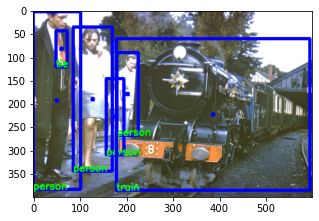

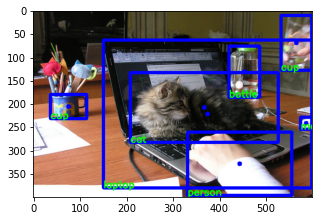

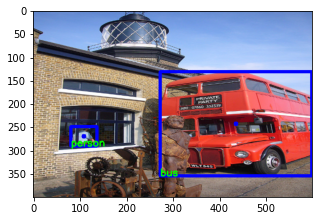

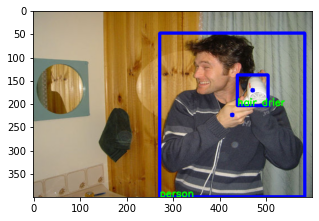

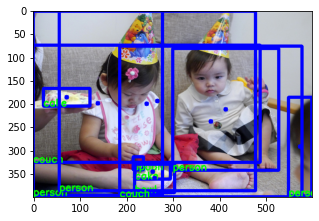

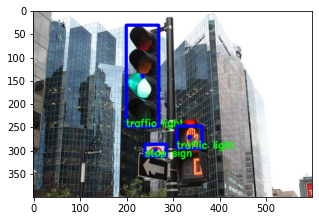

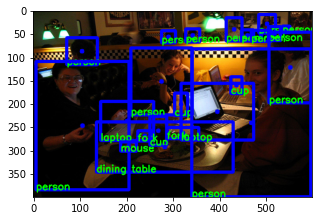

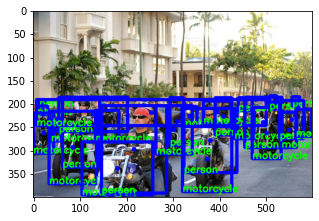

In [16]:
for i in range(a.shape[0]):
    fig, ax = plt.subplots(figsize=(5,5))
    bboxes = DetectionGrid2ImageDetection(d)
    image = Draw_BB(c[i,...], bboxes[i], coco_validation)
    ax.imshow(image)
    plt.show()

# test gen

In [17]:
e,f = test_gen.__next__()

Image_H,Image_W = (427, 640)
Rescaled image dimensions (400, 600, 3)
Parsing...
Done!
Image_H,Image_W = (375, 500)
Rescaled image dimensions (400, 600, 3)
Parsing...
Done!
Image_H,Image_W = (377, 500)
Rescaled image dimensions (400, 600, 3)
Parsing...
Done!
Image_H,Image_W = (276, 500)
Rescaled image dimensions (400, 600, 3)
Parsing...
Done!
Image_H,Image_W = (640, 279)
Rescaled image dimensions (400, 600, 3)
Parsing...
Done!
Image_H,Image_W = (480, 640)
Rescaled image dimensions (400, 600, 3)
Parsing...
Done!
Image_H,Image_W = (427, 640)
Rescaled image dimensions (400, 600, 3)
Parsing...
Done!
Image_H,Image_W = (428, 640)
Rescaled image dimensions (400, 600, 3)
Parsing...
Done!


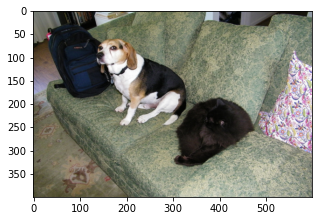

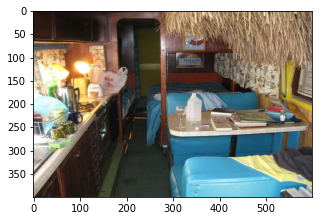

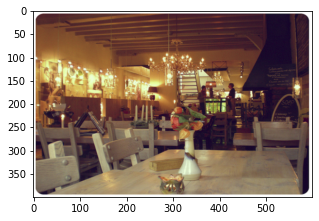

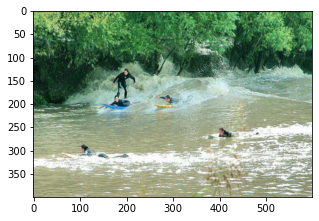

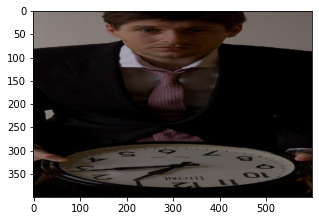

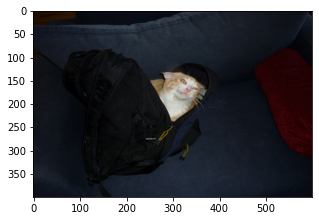

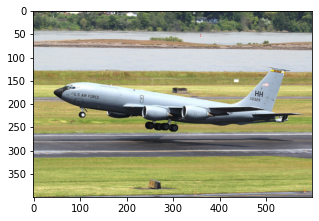

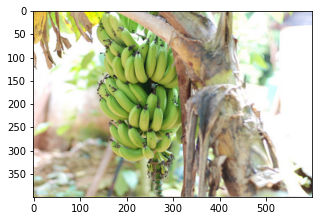

In [18]:
for i in range(a.shape[0]):
    fig, ax = plt.subplots(figsize=(5,5))
    bboxes = DetectionGrid2ImageDetection(f)
    image = Draw_BB(e[i,...], bboxes[i], coco_validation)
    ax.imshow(image)
    plt.show()